## Imports

In [1]:
import numpy as np
from dustpy import hdf5writer
from dustpy import plot
import dustpy.constants as c
import os
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import interp1d

## Reading data

In [2]:
A = hdf5writer.read.sequence("grid.A")
r = hdf5writer.read.sequence("grid.r")
ri = hdf5writer.read.sequence("grid.ri")
ri_coarse = hdf5writer.read.sequence("grid.ri_coarse")
ri_fine = hdf5writer.read.sequence("grid.ri_fine")
rhoDust = hdf5writer.read.sequence("dust.rho")
rhoGas = hdf5writer.read.sequence("gas.rho")
SigmaDust = hdf5writer.read.sequence("dust.Sigma")
SigmaGas = hdf5writer.read.sequence("gas.Sigma")
SigmaPlan = hdf5writer.read.sequence("planetesimals.Sigma")
MPlan = hdf5writer.read.sequence("planetesimals.M")
rPlanet = hdf5writer.read.sequence("planet.r")
t = hdf5writer.read.sequence("t")
Nt, Nr, Nm = SigmaDust.shape

### General information

In [3]:
print("{:4d} snapshots".format(Nt))
print("{:4d} radial grid cells".format(Nr))
print("{:4d} mass bins".format(Nm))

  28 snapshots
 128 radial grid cells
 120 mass bins


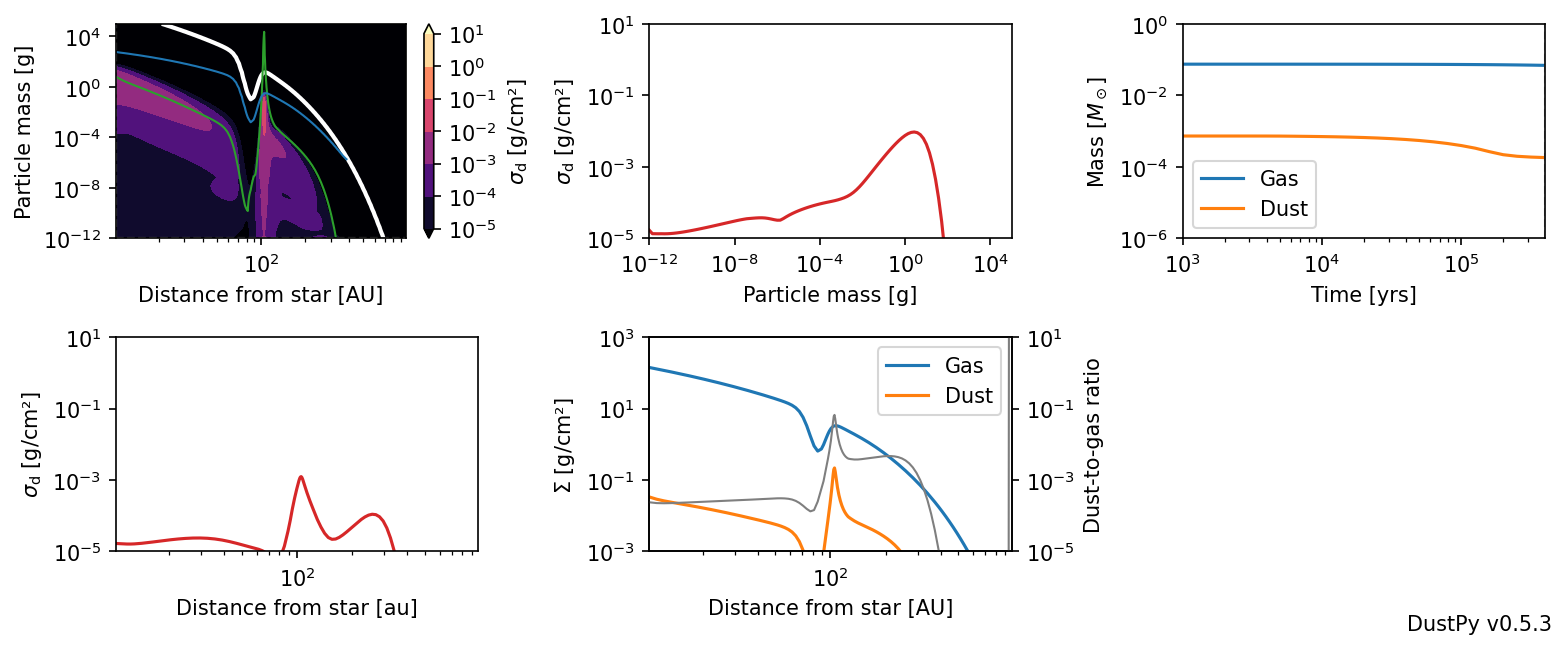

In [4]:
plot.panel("data", it=Nt)

## Data preparation

In [5]:
# Total masses of gas and dust
MGas = (A*SigmaGas).sum(-1)
MDust = (A*SigmaDust.sum(-1)).sum(-1)
# Radial coarse grid
r_coarse = 0.5 * (ri_coarse[:, 1:] + ri_coarse[:, :-1])
A_coarse = np.pi * (ri_coarse[:, 1:]**2 - ri_coarse[:, :-1]**2)

In [6]:
# Peak position and FWHM of dust ring
fwhm = np.empty(Nt)
rpeak = np.empty(Nt)
r1 = np.empty(Nt)
r2 = np.empty(Nt)
for i in range(Nt):
    peak, _ = signal.find_peaks(SigmaDust[i, :, :].sum(-1))
    _, _, i1, i2 = signal.peak_widths(SigmaDust[i, :, :].sum(-1), peak)
    fr = interp1d(np.arange(0, Nr), r[i, :])
    rpeak[i] = fr(peak[-1])
    r1[i] = fr(i1[-1])
    r2[i] = fr(i2[-1])
    fwhm[i] = r2[i] - r1[i]

In [7]:
def find_first(ri, ric):
    i = 0
    while True:
        if np.invert(np.isclose(ri[i+1], ric[i+1])):
            break
        i += 1
    return i

In [8]:
# Transformation of quantities to coarse grid
i = find_first(ri[0, :], ri_coarse[0, :])
m = 0
while True:
    if np.isclose(ri[0, i+m], ri_coarse[0, i+1]):
        break
    m += 1

Nr_coarse = len(ri_coarse[0, :])-1
N = np.int((Nr-Nr_coarse)/(m-1))

SigmaPlan_coarse = np.zeros((Nt, Nr_coarse))
SigmaGas_coarse = np.zeros((Nt, Nr_coarse))
SigmaDust_coarse = np.zeros((Nt, Nr_coarse, Nm))
for it in range(Nt):
    Nstart = find_first(ri[it, :], ri_coarse[it, :])
    Nstop = Nstart + N
    
    SigmaPlan_coarse[it, :Nstart] = SigmaPlan[it, :Nstart]
    SigmaPlan_coarse[it, Nstop:] = SigmaPlan[it, Nstop+N*(m-1):]
    SigmaGas_coarse[it, :Nstart] = SigmaGas[it, :Nstart]
    SigmaGas_coarse[it, Nstop:] = SigmaGas[it, Nstop+N*(m-1):]
    SigmaDust_coarse[it, :Nstart, :] = SigmaDust[it, :Nstart, :]
    SigmaDust_coarse[it, Nstop:, :] = SigmaDust[it, Nstop+N*(m-1):, :]
    
    for ir in range(N):
        i = Nstart+ir*m
        j = Nstart+(ir+1)*m
        
        _Mplan = (A[it, i:j]*SigmaPlan[it, i:j]).sum(-1)
        SigmaPlan_coarse[it, Nstart+ir] = _Mplan/A_coarse[it, Nstart+ir]
        
        _MGas = (A[it, i:j]*SigmaGas[it, i:j]).sum(-1)
        SigmaGas_coarse[it, Nstart+ir] = _MGas/A_coarse[it, Nstart+ir]
        
        _MDust = (A[it, i:j, None]*SigmaDust[it, i:j, :]).sum(-2)
        SigmaDust_coarse[it, Nstart+ir, :] = _MDust/A_coarse[it, Nstart+ir, None]

## Plotting

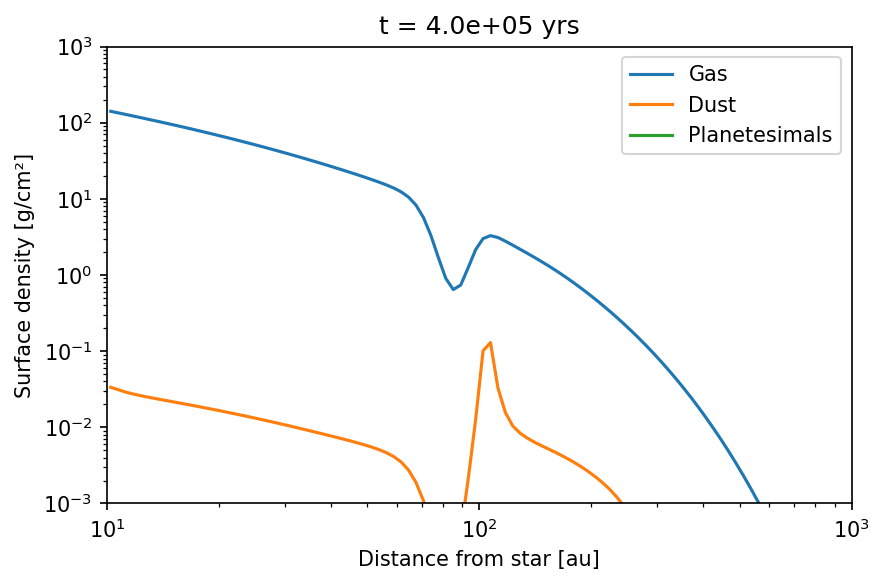

In [9]:
i = -1
fig, ax = plt.subplots(1, 1, dpi=150)
ax.loglog(r_coarse[i, :]/c.au, SigmaGas_coarse[i, :], label="Gas")
ax.loglog(r_coarse[i, :]/c.au, SigmaDust_coarse[i, :, :].sum(-1), label="Dust")
ax.loglog(r_coarse[i, :]/c.au, SigmaPlan_coarse[i, :], label="Planetesimals")
ax.set_xlim(ri[i, 0]/c.au, ri[i, -1]/c.au)
ax.set_ylim(1.e-3, 1.e3)
ax.set_xlabel("Distance from star [au]")
ax.set_ylabel("Surface density [g/cm²]")
ax.set_title("t = {:3.1e} yrs".format(t[i]/c.year))
ax.legend()
fig.tight_layout()

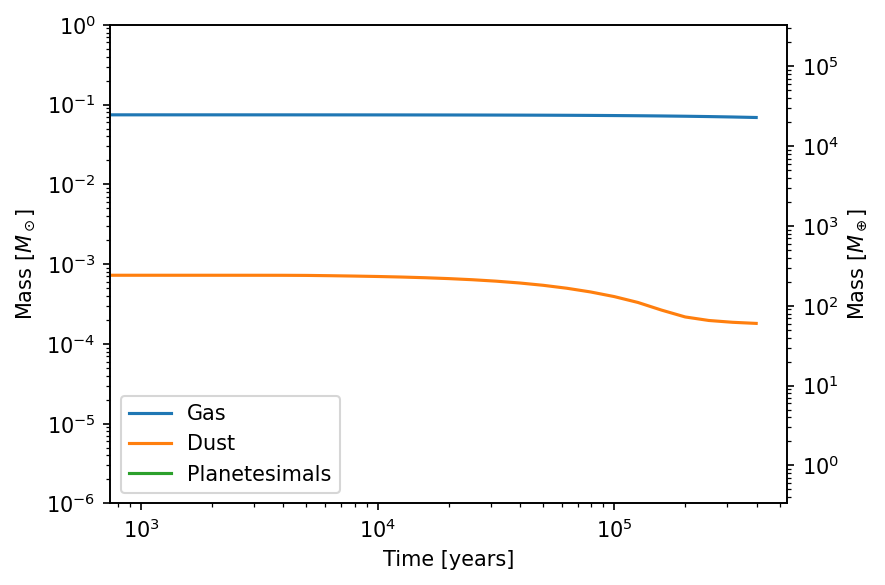

In [10]:
fig, ax = plt.subplots(1, 1, dpi=150)
ax.loglog(t[:]/c.year, MGas/c.M_sun, label="Gas")
ax.loglog(t[:]/c.year, MDust/c.M_sun, label="Dust")
ax.loglog(t[:]/c.year, MPlan/c.M_sun, label="Planetesimals")
ax.set_ylim(1.e-6, 1.e0)
ax.set_xlabel("Time [years]")
ax.set_ylabel("Mass [$M_\odot$]")
ax.legend()
axr = ax.twinx()
axr.set_yscale("log")
axr.set_ylim(ax.get_ylim()[0]*c.M_sun/c.M_earth, ax.get_ylim()[1]*c.M_sun/c.M_earth)
axr.set_ylabel("Mass [$M_\oplus$]")
fig.tight_layout()

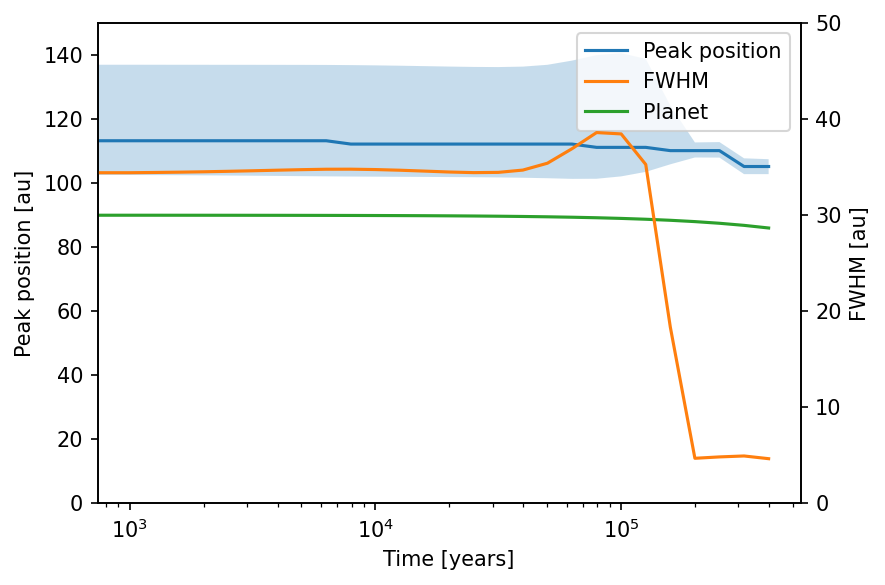

In [11]:
fig, ax = plt.subplots(1, 1, dpi=150)
ax.semilogx(t[:]/c.year, rpeak[:]/c.au, label="Peak position")
ax.fill_between(t[:]/c.year, r1[:]/c.au, r2[:]/c.au, alpha=0.25)
ax.plot(0., 0., c="C1", label="FWHM")
ax.semilogx(t[:]/c.year, rPlanet[:]/c.au, c="C2", label="Planet")
ax.set_ylim(0., 150.)
ax.set_xlabel("Time [years]")
ax.set_ylabel("Peak position [au]")
ax.legend()
axr = ax.twinx()
axr.semilogx(t[:]/c.year, fwhm[:]/c.au, c="C1")
axr.set_ylim(0., 50.)
axr.set_ylabel("FWHM [au]")
fig.tight_layout()